In [750]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

Initial model: create a model that can classify any image as a 3 or a 7

The code blow downloads a sample of MNIST that contains images of just these digits

In [751]:
path = untar_data(URLs.MNIST_SAMPLE)

In [752]:
Path.BASE_PATH = path

In [753]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set).

In [754]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset.

were using sorted to make sure we get same order of files

In [755]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

now we just wanna see what one of the images looks like

In [756]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

this uses the Image class from Python Imaging Library (PIL)
to see the numbers that make up the image, we convert it to a NumPy array / PyTorch tensor

In [757]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

This just shows a section of the image because of the 4:10

Here's the same thing as a pytorch tensor:

In [758]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it
Then we can use pandas datafram to color-code using a gradient:

In [759]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


First idea for teaching a model what's a 3 and what's a 7: Pixel Similarity

- Let's find the average pixel value for every pixel of the 3s and of the 7s.
- We'll get two group averages, defining what might be the ideael 3 and 7
- Then we see which of these two ideal digits the image is most similar to

Let's create a tensor containing all of the 3s stacked together, we'll use Python list comprehension to create a plain list of single image tensors:

In [760]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

let's just double check the images are ok since we now have tensors instead of PIL images. We'll sue fastai's show_image function

<Axes: >

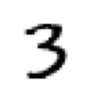

In [761]:
show_image(three_tensors[1])

- For every pixel position, we want to compute the average over all the images of the intensity of that pixel
- First combine all images in this list to a single three-dimensional tensor (rank-3 tensor)
- We often need to stack up individual tensors in a collection into a single tensor (using Pytorch's stack function)
- Let's also cast our stacked tensor to float since some operation in PyTorch require this
- Pixel values are expected to be between 0 and 1, so we divide by 255

In [762]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

- The most important attribute of a tensor is its shape
- This lets us find length of each axis
- Thus we can infer that we have 6131 images with size 28x28

Length of a tensor's shape is its rank:

In [763]:
len(stacked_threes.shape)

3

- RANK: Number of axes or dimensions in a tensor
- SHAPE: size of each axis of a tensor

Finally we can compute what the ideal 3 looks like
- We take the mean of all image tensors by taking mean along dimension 0 of our stacked rank-3 tensor
- For every pixel position, this will compute average of that pixel over all images

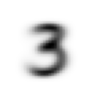

In [764]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

Now we'll do the same thing with the sevens:

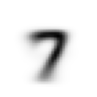

In [765]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Now lets pick an arbitrary 3 and measure its distance from our "ideal digits"

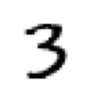

In [766]:
a_3 = stacked_threes[1]
show_image(a_3);

How do we measure distance in this context?
1. Take the mean of the absolute value of differences -> mean absolute difference / L1 norm
2. Take the mean of the square of differences and tehn take the square root -> root mean squared error / L2 norm

Let's try both of these now:


In [767]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [768]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, our 3 and ideal 3 is less than the distance to the ideal 7 so well get the right prediction in this case

PyTorch already provides both of these as loss functions (inside torch.nn.functional) which the team recommends importing as F

In [769]:
import torch.nn.functional as F
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

- MSE stands for mean squared error
- L1 refers to mean absolute value / L1 norm

NumPy is great for scientific and numeric programming in Python, but it doesn't support using GPU or calculating gradients (which PyToch does so were gonna use PyTorch tensors)

were just gonna take a quick dive into numpy and tensors (theyre much faster than pure python and so we should try and use these as much as we can)

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:

In [770]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [771]:
arr # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [772]:
tns # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

Syntax for both are the same. To select a row:

In [773]:
tns[1]

tensor([4, 5, 6])

To select a column, using some list comprehension too

In [774]:
tns[:,1]

tensor([2, 5])

to select part of a row/column:

In [775]:
tns[1,1:3]

tensor([5, 6])

you can use the standard operators such as `+`, `-`, `*`, `/`:

In [776]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

tensors have a type and will automatically change type as needed:

In [777]:
tns.type()

'torch.LongTensor'

In [778]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

METRICS: a number calculated based on prodiction of our model, and correct labels, to tell us how good the model is

This is  going to create tensors for our 3s and 7s from the validation set given to us from MNIST

In [779]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Ultimately we want to write a function (is_3) that will decide if an abritraty image is a 3 or a 7. It'll do this by deciding which of our two "ideal digits" this image is closer to. 

So we need to define a notion of distance (a function that calculates the distance ebtween two images)

In [780]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

to calculate overall accuracy, we need to calculate the distance to the ideal 3 for every image in the validation set

In [781]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1774, 0.1161, 0.1467,  ..., 0.1308, 0.1776, 0.1080]),
 torch.Size([1010]))

Instead of complaining about shapes not matches, it returned distance for every single image as a vector

The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank.

We can use mnist_distance to tell us whether an image is a 3 or not by using the following logic:
- If the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7 then its a 3

In [782]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Now lets calculate the accuracy for each of the 3s and 7s but taking the average of that function for all 3s and its inverse for 7s.

In [783]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

STOCHASTIC GRADIENT DESCENT EXAMPLE

Let's say that our loss function is the quadratic function and x is a weight parameter of the function:

In [784]:
def f(x): return x**2

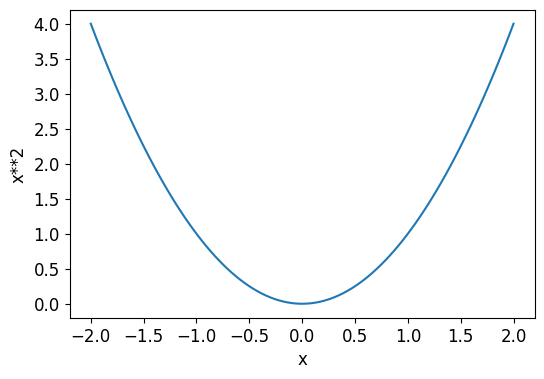

In [785]:
plot_function(f, 'x', 'x**2')

First we start by picking some random value for a parameter and calculating the value of the loss:

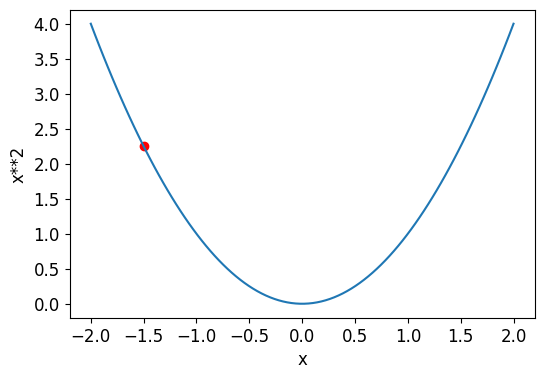

In [786]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Next we look at what would happen if we increased or decreased our parameter by a little bit - the adjustment:

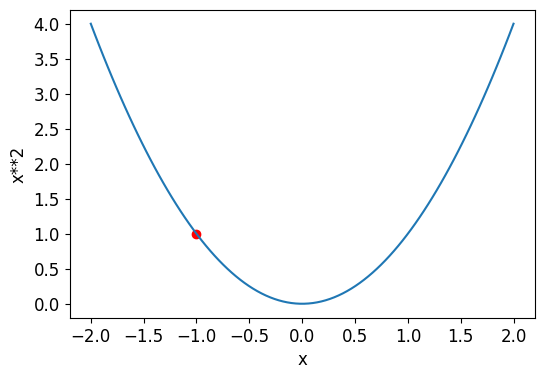

In [787]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1, f(-1), color='red');

We can continue to change our weight little by little but eventually we should get to the lowest point on the curve:

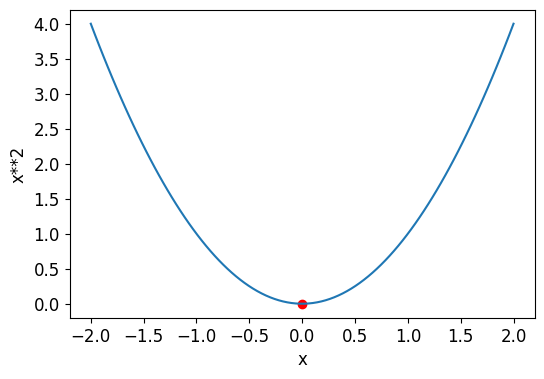

In [788]:
plot_function(f, 'x', 'x**2')
plt.scatter(0, f(0), color='red');

BUT HOW DO WE CALCULATE GRADIENTS! WE USE PYTORCH!!!

Let's see an example. First, let's pick a tensor values which we want gradients at. The requires_grad_ tells PyTorch taht we want to calculate gradients with respect to that variable at that value.

In [789]:
xt = tensor(3.).requires_grad_()

Next, we calculate our function with that value.

In [790]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us

In [791]:
yt.backward()

Backward refers to backpropogation, the name given to the process of calculating the derivative of each layer. 

This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated

Now we can view the gradients by checking the grad attribute of the tensor:

In [792]:
xt.grad

tensor(6.)

Awesome! It worked. Now we're going to make the example more complicated by using a vecotr argument for our function:

In [793]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

We'll add sum to our function so it can take a vector (rank-1 tensor) and return a scalar (rank-0 tensor):

In [794]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [795]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

SGD EXAMPLE TO SEE HOW FINDING A MINIMUM CAN BE USED TO TRAIN A MODEL TO FIT DATA BETTER

Let's say we meausre speed of a roller coaster as it went over the top of a hump. It would start fast, slow down as it went up hill, be slowest at top, then speed up as it went downhill. You want to build a model of how speed changes over time. Let's say we measure speed manually every second for 20 seconds:

In [796]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

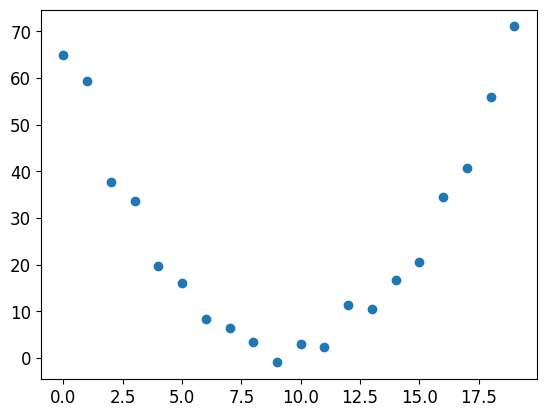

In [797]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

Not easy to say what the roller coaster's speed is. But, we can use SGD to find a function that matches our observations. Let's guess that the function is quadratic.

We want to clearly distinguish between the funciton's input (time when we are measure the coaster's speed) and its parameters (the values that define which quadratic we're trying). Let's collece the parameters in one argument and separate the input, t, and the parameters, params, in the function signature:

In [798]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

Instead of finding the best function that fits our data, were finding the best qudratic function. To find the best quadratic function we just need to find the best value for a, b, and c.

We need to first define what best is. So we need to define a loss function which will return a value based on a prediction and a target, where lower values of the function mean better predictions.

It needs to return lower values for better prediction, as the SGD procedure will try to minimize the loss.

For continuous data, its common to use mean squared error:

In [799]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now we go through the 7 step process

First initialize parameters to random values and tell PyTorch we want to track their gradients:

In [800]:
params = torch.randn(3).requires_grad_()

In [801]:
orig_params = params.clone()

Now, we calculate the predictions

In [802]:
preds = f(time, params)

Let's create a function to see how clsoe the prediction are to the target:

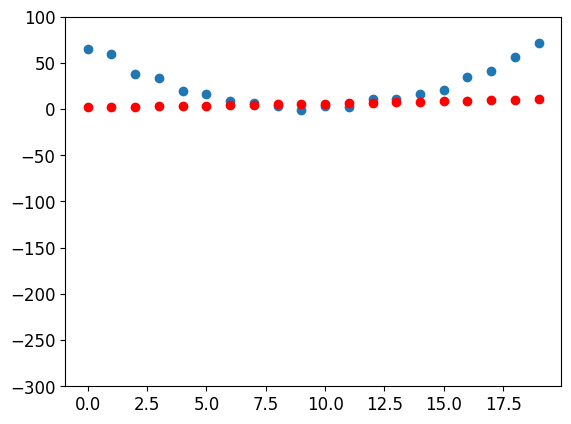

In [803]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
    
show_preds(preds)

Not very close

Let's calculate the loss as follows:

In [804]:
loss = mse(preds, speed)
loss

tensor(875.3926, grad_fn=<MeanBackward0>)

Let's calculate the gradients (i.e. calculate an approximation of how the parameters need to change):

In [805]:
loss.backward()
params.grad

tensor([-5782.7510,  -355.4456,   -39.6303])

We can use these gradients to improve our parameters. Let's set the learning rate to 1e-5

In [806]:
params.grad * 1e-5

tensor([-0.0578, -0.0036, -0.0004])

Now we need to update the parameters based on the gradients:

In [807]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Let's see if loss has improved:

In [808]:
preds = f(time,params)
mse(preds, speed)

tensor(634.5391, grad_fn=<MeanBackward0>)

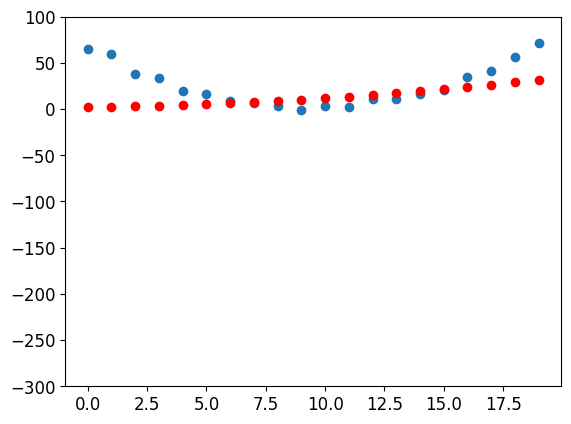

In [809]:
show_preds(preds)

It has! Now we need to repeat a few times, so we'll create a function to apply one step:

In [810]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

for i in range(10): apply_step(params)

634.5390625
588.9586181640625
580.3297729492188
578.6932983398438
578.3800048828125
578.3170776367188
578.3015747070312
578.2950439453125
578.2901000976562
578.2855224609375


In [811]:
params = orig_params.detach().requires_grad_()

The loss is going down! Each iteration represents an entirely different quadratic function being tried. So let's see this process visually and plot the function at every step:

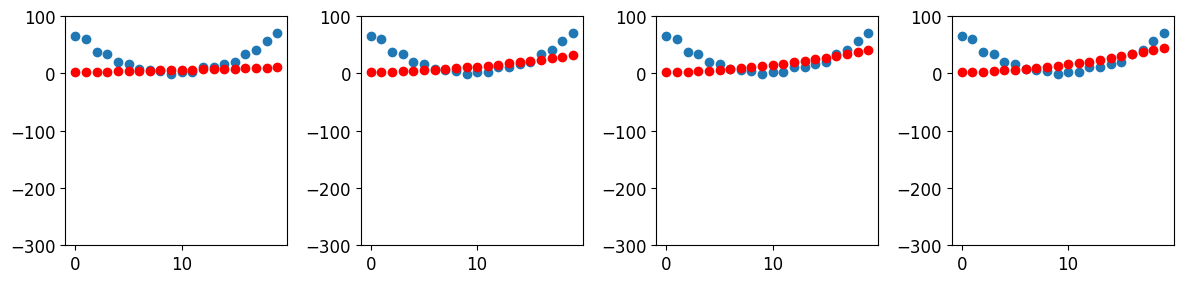

In [812]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

WITH SGD OUT OF THE WAY LET'S RETURN TO THE DIGIT SIMILARITY PROBLEM

The independent variable x is the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of rank-3 tensors to a list of rank-2 tensors. 

This is done using view, a PyTorch method that changes the shape of a tensor without changing its contents.

-1 is a special paramter to view that tells PyTorch to make this axis as big as necessary to fit all the data

In [813]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Each image needs a label so we'll use 1 for 3s and 0 for 7s:

In [814]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A dataset in PyTorch is required to return a tuple of (x,y) when indexed so we'll use Python's zip function to combine these two lists:

In [815]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [816]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Next, we'll need an initial random weight for every pixel (the initialize step):

In [817]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [818]:
weights = init_params((28*28,1))

The function weights*pixels isn't flexible enough since it'll always equal to 0 when the pixels are equal to 0 (its intercept is 0). So we'll initalize the intercept to a random number too:

In [819]:
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

Now let's calculate a prediction for one image:

In [820]:
(train_x[0]*weights.T).sum() + bias

tensor([9.5425], grad_fn=<AddBackward0>)

Don't use for loop to predict each image:
- Python doesn't run on GPU
- Python is slow language for loops

We need to represent as much of the computation in a model as possible using higher-level functions

We can use matrix multiplication to calculate w*x for every row of a matrix

Matrix multiplication is represented with the @ operator in Python:

In [821]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 9.5425],
        [ 2.9833],
        [ 9.2650],
        ...,
        [-2.5356],
        [14.6461],
        [-1.6888]], grad_fn=<AddBackward0>)

- First element is same as before (expected)
- This equation batch@weights + bias is one of fundamental equatios of any neural network

Let's check accuracy (easy since we can just check whether output is greater than 0):

In [822]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [ True]])

In [823]:
corrects.float().mean().item()

0.7029687166213989

Now let's see what happens to the accuracy if we make a small change in one of the weights
- We have to ask PyTorch not to calculate gradients as we do this:

In [824]:
with torch.no_grad(): weights[0] *= 1.0001

In [825]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.7029687166213989

Therefore, we need gradients to improve our mudel using SGD
- To calculate gradients we need some loss function to represent how good our model is
- Gradients are a measure of how that loss function changes with small tweaks to weights

We need to define a loss function. 

So far all we can go off of is seeing what happens to accuracy when we change the weights

Now were going to implement one where if the correct answer is a 3 the score is a little higher, if its a 7 then the score is a little lower  

One argument, prds, of values between 0 and 1, is the prediction that an image is a 3. Its a rank-1 tensor indexed over the images

The whole point of this loss function is to measure the difference between the predicted values and the targets

So we need another argument, trgts, of values 0 or 1, that tell us whether an image is a 3 or not. Its a rank-1 tensor indexed over the images

Let's say we have three images which we know are a 3, 7, and 3.

Let's say the model predicted the images with the following confidence: 0.9, 0.4, 0.2

Our loss function gets these inputs:

In [826]:
trgts  = tensor([1  ,   0  ,    1   ])
prds   = tensor([0.9,   0.4,    0.2 ])

Let's try a loss function that measures the distance between predictions and targets:
- The function torch.where(a,b,c) is the same as [b[i] if a[i] else c[i] for i in range(len(a))]
- Except that it works on tensors using the GPU
- This function measures how distance each prediction is from 1 if it should be 1, and same thing from 0 if it should be 0
- Then it takes the mean of all the distances

In [827]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

Trying it on example prds and trgts:

In [828]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

Thus, it returns lower numbers when predictions are more accurate, when accurate predictions are more confident, and when inaccurate predictions are less confident

Since we need a scalar for the final loss, mnist_loss takes the mean of the previous tensor

In [829]:
mnist_loss(prds,trgts)

tensor(0.4333)

### Sigmoid

Sigmoid function always outputs a number between 0 and 1. We need this function because to ensure predictions are always be between 0 and 1.

In [830]:
def sigmoid(x): return 1/(1+torch.exp(-x))

PyTorch already has an accelerated version for us, so we don't need to make one ourself.

Essential function in deep learning, since we often want to ensure values are between 0 and 1

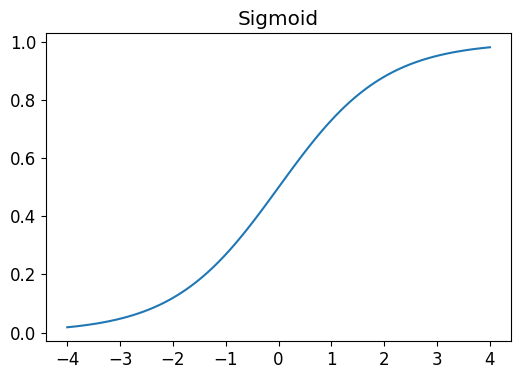

In [831]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

This function takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1.

Its curve also only goes up, making it easier for SGD to find meaningful gradients

Now lets update mnist_loss to first apply sigmoid to the inputs:
- Now we can be confident that our loss function will work even when predictions are not between 0 and 1
- All we need is that a higher prediction means higher confidence an image is a 3

In [832]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now that we've got a proper loss function for SGD, we need to change/update the weights based on the gradients

Were going to calculate the average loss for a few data items at a time so we get a more precise gradient for model to learn from

To make the generalization of the model better, we want to vary the data used to train the model. So we're going to use a DataLoader and turn it into an iterator over mini-batches. We want to randomly shuffle the dataset on every epoch before creating mini-batches

Here's an example implementing DataLoader to show how an input of data can be turned into mini-batches

In [833]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 7, 14,  3,  0,  6]),
 tensor([ 1, 12, 10,  5,  8]),
 tensor([13,  9,  4,  2, 11])]

E.g. 2

Models need to know the targets too, so here's an example that creates a tuple (x,y) where x is the input and y is the target

This collection is called a Dataset (ds) in PyTorch:

In [834]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a Dataset to a DataLoader we will get back mini-batches which are tuples of tensors representing batches of inputs and targets:

In [835]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 1, 10,  7,  9, 24, 17]), ('b', 'k', 'h', 'j', 'y', 'r')),
 (tensor([ 6, 12, 16, 15, 19,  2]), ('g', 'm', 'q', 'p', 't', 'c')),
 (tensor([ 0, 20,  5, 23,  3, 25]), ('a', 'u', 'f', 'x', 'd', 'z')),
 (tensor([ 4,  8, 21, 11, 13, 14]), ('e', 'i', 'v', 'l', 'n', 'o')),
 (tensor([18, 22]), ('s', 'w'))]

Now let's create a training loop for the model that uses SGD:

Initialize parameters:
- weights = init_params((28*28, 1)): 
    - This initializes the weights matrix with dimensions (784, 1). 
    - Each element in the input vector (flattened image) will have a corresponding weight.
- bias = init_params(1): 
    - This initializes the bias term as a single scalar value.

Together, the weights and bias are used to compute the weighted sum of the input features plus the bias, which is then used to make a prediction.

In [836]:
weights = init_params((28*28,1))
bias = init_params(1)

Create DataLoader from a Dataset:

In [837]:
dl = DataLoader(dset, batch_size=256)
# dset contains data and target for all 3s and 7s
valid_dl = DataLoader(valid_dset, batch_size=256)
# valid_dset is same as dset but from validation folder

xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

Create a mini-batch of size 4 for testing:

In [838]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [839]:
preds = linear1(batch)
# runs xb@weights + bias on all items in batch
preds

tensor([[ 0.7379],
        [ 0.0706],
        [13.4034],
        [-0.3394]], grad_fn=<AddBackward0>)

In [840]:
loss = mnist_loss(preds, train_y[:4])
# find the loss for each prediction
loss

tensor(0.3475, grad_fn=<MeanBackward0>)

calculating gradient:

In [841]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0274), tensor([-0.1779]))

In [842]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0548), tensor([-0.3557]))

Running it a bunch of times changes gradient because loss.backward adds gradients of loss to any gradients currently stored :(

So we need to set current gradients to 0 first:

In [843]:
weights.grad.zero_()
bias.grad.zero_();

Now we need to update the weights and biases based on the gradient and learning rate. 

We have to tell PyTorch not to take the gradeitn of this step too. So we assign the data attribute then PyTorch will not take the gradient of that step:

In [844]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing by looking at the accuracy of the validation set. To see if an output is a 3 or a 7 we just check whether its greater than 0. So accuracy for each item can be calculated with:

In [845]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [ True],
        [False]])

In function format:

In [846]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

batch_accuracy(linear1(batch), train_y[0:4])

tensor(0.7500)

In [847]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.5311

This is our starting point. Let's train for one epoch and see if accuracy improves:

In [848]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6452

Then do a few more:

In [849]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8305 0.9194 0.9467 0.9584 0.9638 0.9667 0.9687 0.9692 0.9706 0.9716 0.9716 0.9726 0.9726 0.9731 0.9736 0.9736 0.9736 0.9741 0.9741 0.9755 

Great! So now we have same accuracy as pixel similarity approach, and we've create a general purpose foundation we can build on. 

Next step is to create an object that will handle the SGD step for us.

In PyTorch this is called the optimizer

Because we are using such a general foundation, PyTorch has some useful classes to make it easier to implement an optimizer.

First: Let's replace our linear1 function with PyTorch's nn.Linear module (an object of a class that inherits from the PyTorch nn.Module class)

nn.Linear does the same thing as our init_paramas and linear together. Contains both the weights and biases in a single class. Here's how to replicate our model from the previous section:

In [850]:
linear_model = nn.Linear(28*28,1)

We can figure out what parameters it has that can be trained using parameters method:

In [851]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We use this information to create an optimizer:

In [852]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

Then we create our optimizer by passing in the model's parameters:

In [853]:
opt = BasicOptim(linear_model.parameters(), lr)

Now we can make our training loop much simpler:

In [854]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

We'll keep validation function the exact same way:

In [855]:
validate_epoch(linear_model)

0.2723

Then, let's simplify things even more by putting our training loop in a function: 

In [856]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

Results are exact same as before:

In [857]:
train_model(linear_model, 20)

0.4932 0.5055 0.6621 0.8779 0.9194 0.938 0.9521 0.958 0.9638 0.9658 0.9682 0.9697 0.9717 0.9741 0.9741 0.9761 0.977 0.9775 0.978 0.978 

fastai provies the SGD class which does the same thing as our BasicOptim

In [858]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8232 0.8437 0.9136 0.9336 0.9477 0.9575 0.9634 0.9658 0.9668 0.9692 0.9712 0.9741 0.9746 0.9761 0.977 0.9775 0.9785 0.9785 0.979 

fastai also providees Learner.fit which we can use instead of train_model.

To create a learner we need to create a DataLoaders by passing in our training and validation DataLoaders:

In [859]:
dls = DataLoaders(dl, valid_dl)

To create a learner without using an application (such as vision_learner) we need to pass all the elements we've created so far:
- the DataLoaders
- the model
- the optimization function (which will be passed the parameters)
- the loss function
- metrics to print

In [860]:
learn = Learner(
    dls,
    nn.Linear(28*28,1),
    opt_func=SGD,
    loss_func=mnist_loss,
    metrics=batch_accuracy
)

Now let's call fit:

In [861]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637089,0.502487,0.495584,00:00
1,0.347420,0.280807,0.727184,00:00
2,0.133979,0.154092,0.862120,00:00
3,0.062691,0.097470,0.918548,00:00
4,0.036190,0.073327,0.935721,00:00
5,0.025617,0.059761,0.949460,00:00
6,0.021122,0.051142,0.956820,00:00
7,0.019023,0.045308,0.964181,00:00
8,0.017892,0.041148,0.965653,00:00
9,0.017173,0.038045,0.967615,00:00


Therefore, there's nothing magic about PyTorch and fastai. They just add convenient pre-packaged pieces 

So with these classes, now we're going to replace the lienar model with a neural network:

## Adding a Nonlinearity

So far we have a procedure for optimizing the parameters of a function, a boring function: a simple linear classifier

A linear classifier is super constrained in what it can do

So we need to make it a little more complex (and able to handle more tasks), we need to add something non linear between two linear classifiers -> this is what gives us a neural network

Here's a super simple example of a neural network:

In [862]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

All we do is use a max function between two linear classifiers

w1 and w2 are weight tensors
b1 and b2 are bias tensors

These are parameters that are initially randomly initialized just like before

In [863]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

w1 has 30 output activations
- This means w2 must have 30 input activations, so they match

Therefore the first layer can construct 30 different features, each representing some different mix of pixels

res.max(tensor(0.0)) is called a rectified linear unit (ReLu)
- It just replaces every negative number with a zero and PyTorch offers it with F.relu

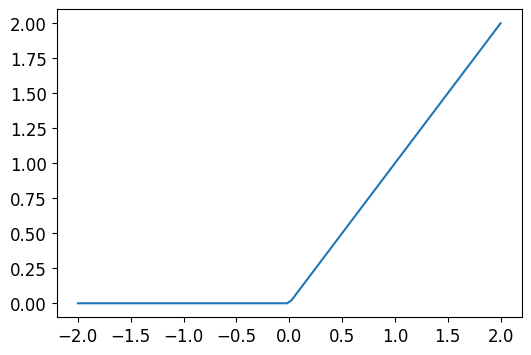

In [864]:
plot_function(F.relu)

Basic idea: more linear layers = model do more computation = model more complex functions
- But no point in putting linear layer after another cause that can just be replaced as one 
- Need to put a nonlinear function between them such as max
- This decouples each layer

So we can replace this code with something a bit simpler by taking advantage of PyTorch
- The first and third lines are linear layers
- The second line provides nonlinearity, so its an activation function

nn.Sequential creates a module that will call each of the listed layers or function in turn

nn.ReLu replaces all negative numbers with 0

nn.linear contains both the weights and biases in a single class

In [865]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

Since nn.Sequential is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. SInce this is a deeper model, we'll use a lower learning rate and more epochs:

In [866]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [867]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.302103,0.414610,0.504416,00:00
1,0.143450,0.222009,0.814524,00:00
2,0.079629,0.111824,0.919038,00:00
3,0.052481,0.075768,0.943081,00:00
4,0.039876,0.059283,0.959764,00:00
5,0.033424,0.050052,0.965653,00:00
6,0.029711,0.044246,0.966634,00:00
7,0.027297,0.040288,0.968597,00:00
8,0.025558,0.037412,0.969578,00:00
9,0.024214,0.035215,0.971050,00:00


The training process is recorded in learn.recorder, with table of output stored in the values attribute.

We can plot the accuracy over training as:

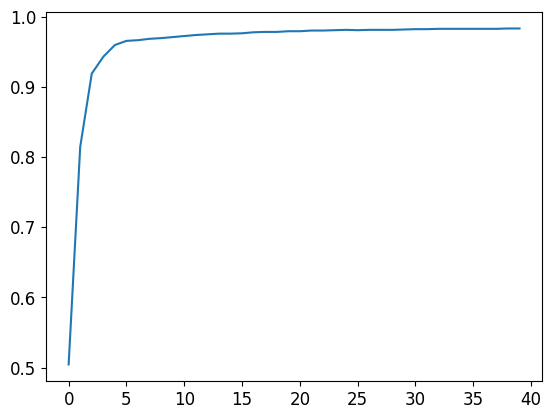

In [868]:
plt.plot(L(learn.recorder.values).itemgot(2));

Final accuracy:

In [869]:
learn.recorder.values[-1][2]

0.983316957950592

To recap:
- We have a function that can solve any probelm to any level of accuracy (neural network) given correct set of parameters
- We have a way to find the best set of parameters for any function (stochastic gradient descent)

### Going Deeper

No need to stop at just two linear layers -> we can keep adding more as long as we add nonlinearity between each pair of linear layers

With a deeper model we do not need to use as many paremeters, smaller matricies with more layers gets better results than larger matrices with few layers

We can train the model more quickly and take up less memory

Here's what happens when we train an 18 layer model using same approach as we saw in ch1

In [870]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.060135,0.005332,0.998528,00:12
